# Melanoma Image Classification

Skin cancer is the most prevalent type of cancer. Melanoma, specifically, is responsible for 75% of skin cancer deaths, despite being the least common skin cancer. The American Cancer Society estimates over 100,000 new melanoma cases will be diagnosed in 2020. It's also expected that almost 7,000 people will die from the disease. As with other cancers, early and accurate detection—potentially aided by data science—can make treatment more effective.

Currently, dermatologists evaluate every one of a patient's moles to identify outlier lesions or “ugly ducklings” that are most likely to be melanoma. Existing AI approaches have not adequately considered this clinical frame of reference. Dermatologists could enhance their diagnostic accuracy if detection algorithms take into account “contextual” images within the same patient to determine which images represent a melanoma. If successful, classifiers would be more accurate and could better support dermatological clinic work.

As the leading healthcare organization for informatics in medical imaging, the Society for Imaging Informatics in Medicine (SIIM)'s mission is to advance medical imaging informatics through education, research, and innovation in a multi-disciplinary community. SIIM is joined by the International Skin Imaging Collaboration (ISIC), an international effort to improve melanoma diagnosis. The ISIC Archive contains the largest publicly available collection of quality-controlled dermoscopic images of skin lesions.

In this competition, you’ll identify melanoma in images of skin lesions. In particular, you’ll use images within the same patient and determine which are likely to represent a melanoma. Using patient-level contextual information may help the development of image analysis tools, which could better support clinical dermatologists.

Melanoma is a deadly disease, but if caught early, most melanomas can be cured with minor surgery. Image analysis tools that automate the diagnosis of melanoma will improve dermatologists' diagnostic accuracy. Better detection of melanoma has the opportunity to positively impact millions of people.

## Project Purpose

To create a model that can predict, given an image, if a patient's mole is likely to be melanoma.  This model will then be deployed to an iOS app.  An individual could use the app to decide if they should see a dermatologist for further review of a mole.  

## Exploratory Data Analysis

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
#from tensorflow.keras.applications import EfficientNetB6

#from efficientnet.keras import EfficientNetB3

In [5]:
#https://www.kaggle.com/ibtesama/siim-baseline-keras-vgg16
train_dir='C:/Users/mgffr/OneDrive/Desktop/2020 Fall/MSDS 462/Final Project/Data/train/'
test_dir='C:/Users/mgffr/OneDrive/Desktop/2020 Fall/MSDS 462/Final Project/Data/test/'
train=pd.read_csv('C:/Users/mgffr/OneDrive/Desktop/2020 Fall/MSDS 462/Final Project/Data/train.csv')
test=pd.read_csv('C:/Users/mgffr/OneDrive/Desktop/2020 Fall/MSDS 462/Final Project/Data/test.csv')
submission=pd.read_csv('C:/Users/mgffr/OneDrive/Desktop/2020 Fall/MSDS 462/Final Project/Data/sample_submission.csv')
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

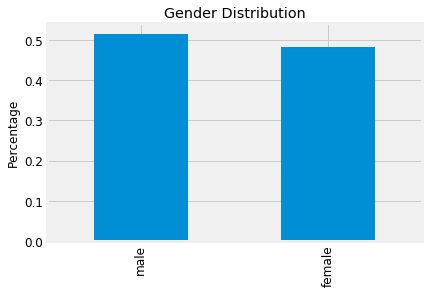

In [7]:
ax = train['sex'].value_counts(normalize=True).plot(kind='bar', title ="Gender Distribution", fontsize=12)
ax.set_ylabel("Percentage", fontsize=12)
plt.show()

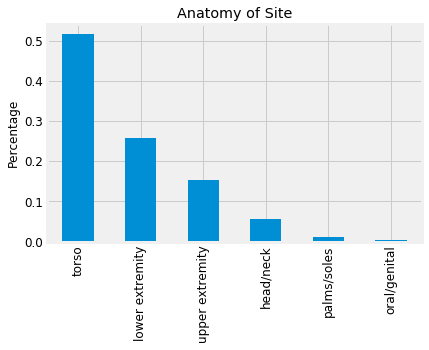

In [8]:
ax = train['anatom_site_general_challenge'].value_counts(normalize=True).plot(kind='bar', 
                                                                              title ="Anatomy of Site", fontsize=12)
ax.set_ylabel("Percentage", fontsize=12)
plt.show()

Gender distirbituion is slightly more favored towards males but for the most part is fairly balanced. The majority of the images were taken of the torso, arms, and legs, with few images occuring on the head/neck, palms, or other regions.  

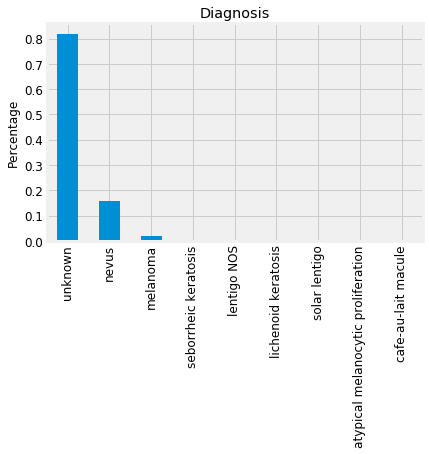

In [9]:
ax = train['diagnosis'].value_counts(normalize=True).plot(kind='bar',title ="Diagnosis", fontsize=12)
ax.set_ylabel("Percentage", fontsize=12)
plt.show()

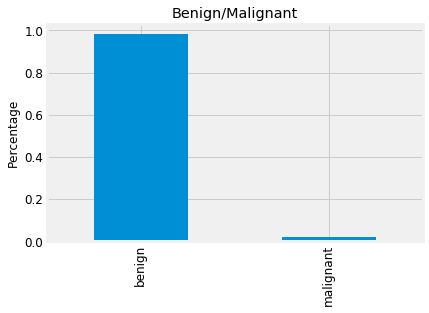

In [10]:
ax = train['benign_malignant'].value_counts(normalize=True).plot(kind='bar', title ="Benign/Malignant", fontsize=12)
ax.set_ylabel("Percentage", fontsize=12)
plt.show()

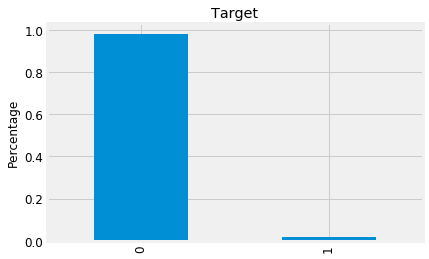

In [11]:
ax = train['target'].value_counts(normalize=True).plot(kind='bar', 
                                                                              title ="Target", fontsize=12)
ax.set_ylabel("Percentage", fontsize=12)
plt.show()

Most moles have an unknown diagnosis, falling in the benign category.  The target variable is extremely unbalanced. The target variable is just benign/malignant converted to 0/1.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


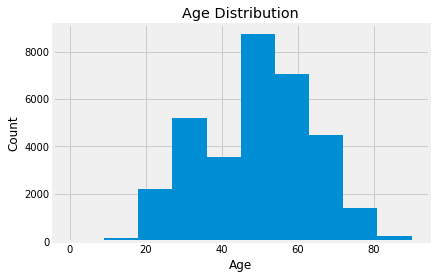

In [12]:
plt.hist(train['age_approx'])
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

The distiribution of ages is centered around 50 with a slight skew.  

### Training/Test Differences

In [13]:
train['dataset'] = 'train'
test['dataset'] = 'test'

In [14]:
tr_te = pd.concat([train, test])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


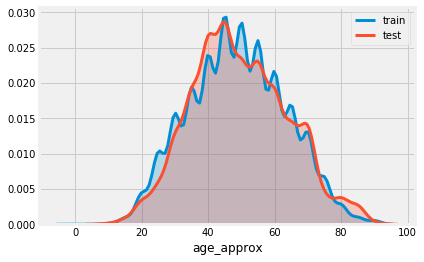

In [15]:
import seaborn as sns
for datasets in pd.unique(tr_te['dataset']):
    # Subset to the airline
    subset = tr_te[tr_te['dataset'] == datasets]
    
    # Draw the density plot
    sns.distplot(subset['age_approx'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = datasets)

Age is similar between the training data set and the test dataset.

### Missing Values

In [16]:
#https://www.kaggle.com/nxrprime/siim-d3-eda-augmentations-and-resnext
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [17]:
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 9 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
anatom_site_general_challenge,527,1.6
age_approx,68,0.2
sex,65,0.2


In [18]:
missing_values = missing_values_table(test)
missing_values.head(20)

Your selected dataframe has 6 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
anatom_site_general_challenge,351,3.2


The location of the picture is missing 1.6% of the time in the training dataset whereas it is missing 3.2% of the time in the test set.  Age and Sex are missing .2% of the time in the training dataset whereas they are never missing in the test dataset.

### Violin Plots

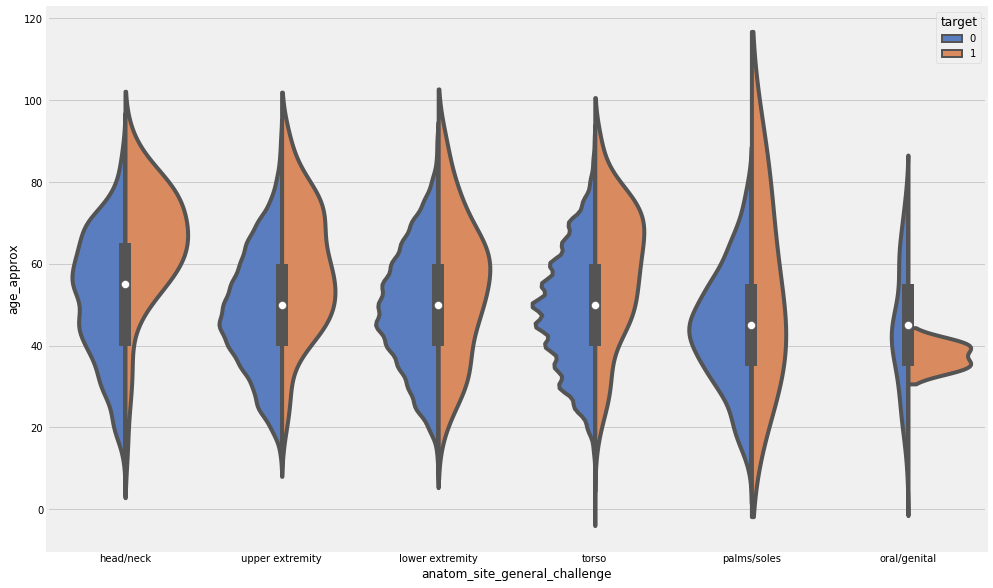

In [19]:
fig=plt.figure(figsize=(15, 10))
sns.violinplot(x="anatom_site_general_challenge", y="age_approx", hue="target",
                    data=train, palette="muted", split=True)

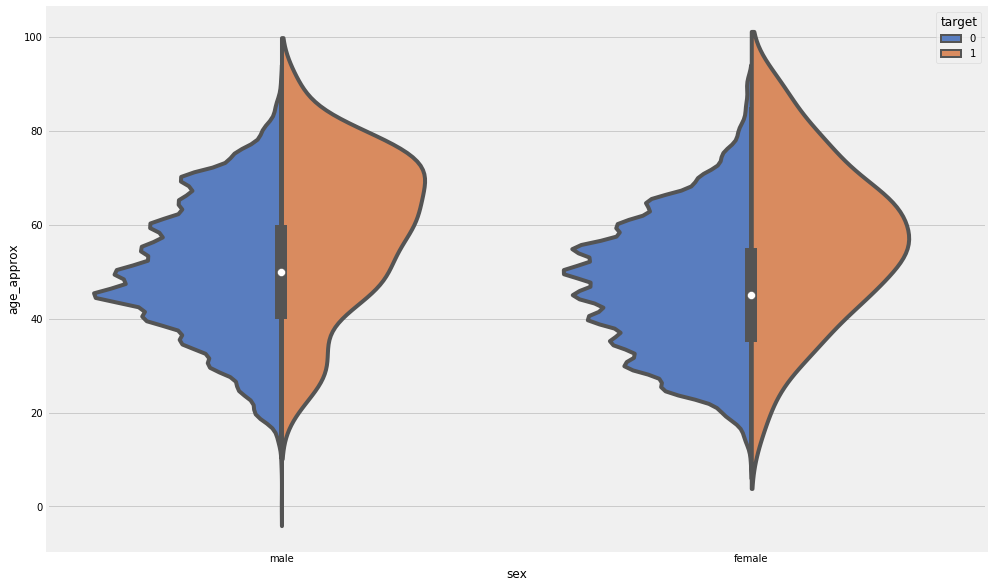

In [20]:
fig=plt.figure(figsize=(15, 10))
sns.violinplot(x="sex", y="age_approx", hue="target",
                    data=train, palette="muted", split=True)

In [21]:
labels=[]
data=[]
for i in range(train.shape[0]):
    data.append(train_dir + train['image_name'].iloc[i]+'.jpg')
    labels.append(train['target'].iloc[i])
df=pd.DataFrame(data)
df.columns=['images']
df['target']=labels

test_data=[]
for i in range(test.shape[0]):
    test_data.append(test_dir + test['image_name'].iloc[i]+'.jpg')
df_test=pd.DataFrame(test_data)
df_test.columns=['images']

X_train, X_val, y_train, y_val = train_test_split(df['images'],df['target'], test_size=0.2, random_state=1234)

train=pd.DataFrame(X_train)
train.columns=['images']
train['target']=y_train

validation=pd.DataFrame(X_val)
validation.columns=['images']
validation['target']=y_val

train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,horizontal_flip=True)
val_datagen=ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    target_size=(128, 128),
    batch_size=8,
    shuffle=True,
    class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(128, 128),
    shuffle=False,
    batch_size=8,
    class_mode='raw')

Found 26500 validated image filenames.
Found 6626 validated image filenames.


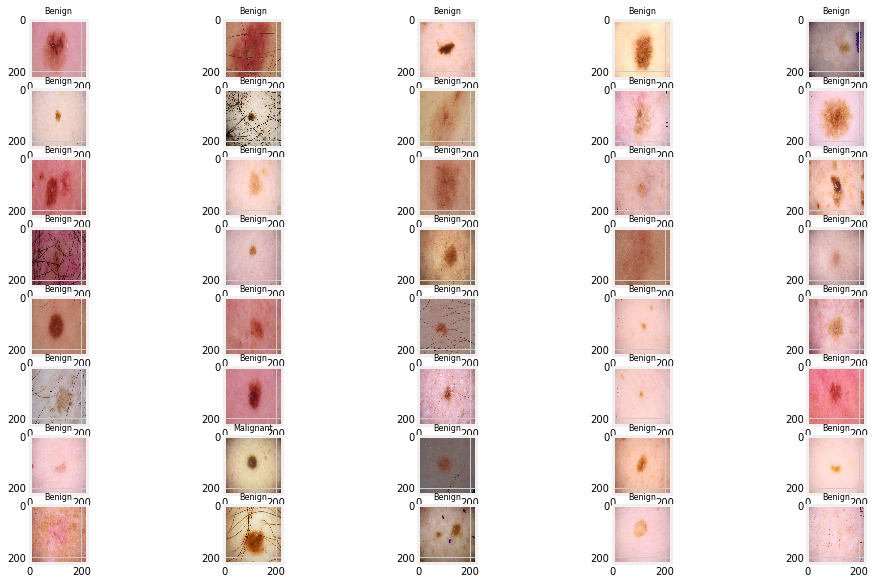

In [22]:
import cv2

fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 8
class_names = ['Benign', 'Malignant']

for i in range(1, columns*rows +1):
    img=cv2.imread(validation.images.iloc[i])
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(class_names[validation.target.iloc[i]], fontsize=8)
    fig.add_subplot

## EfficientNetB6 Model

In [24]:
from tensorflow.keras.models import Sequential

In [22]:
enet = EfficientNetB6(input_shape=(128, 128, 3), weights='imagenet',include_top=False) 

In [23]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * 1 * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

In [24]:
from keras.layers import GlobalAveragePooling2D

In [30]:
model = Sequential(enet)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=1, use_bias=True, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['AUC'])

In [32]:
fit = model.fit_generator(train_generator, steps_per_epoch=3312, epochs=3,
                         validation_data=validation_generator, validation_steps=828,
                         callbacks = [get_lr_callback(256)])

Epoch 1/3
3312/3312 [==============================] - 3657s 1s/step - loss: 0.1383 - auc: 0.6154 - val_loss: 0.0725 - val_auc: 0.8024
Epoch 2/3
3312/3312 [==============================] - 3512s 1s/step - loss: 0.0824 - auc: 0.7680 - val_loss: 0.0760 - val_auc: 0.7600
Epoch 3/3
3312/3312 [==============================] - 3391s 1s/step - loss: 0.0802 - auc: 0.7869 - val_loss: 0.0721 - val_auc: 0.8164


### Attempting to convert model to .mlmodel using coremltools

In [43]:
coreml_model = coremltools.converters.keras.convert(model,
    input_names="image",
    image_input_names="image",
    image_scale=1/255.0,
    class_labels=['Benign', 'Malignant'],
    is_bgr=True)

ValueError: Keras layer '<class 'tensorflow.python.keras.layers.preprocessing.image_preprocessing.Rescaling'>' not supported. 

## Building A CNN Without EfficientNet

In [46]:
model_test = Sequential()
model_test.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                        input_shape=(128, 128, 3)))
model_test.add(MaxPool2D((2, 2),strides=2))
model_test.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model_test.add(MaxPool2D(pool_size=(2, 2),strides=2))
model_test.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model_test.add(MaxPool2D(pool_size=(2, 2),strides=2))
model_test.add(Flatten())
model_test.add(Dense(units=1, activation='sigmoid'))

In [47]:
model_test.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
fit = model_test.fit_generator(train_generator, steps_per_epoch=5, epochs=10,
                         validation_data=validation_generator, validation_steps=5)

Epoch 1/10
5/5 [==============================] - 9s 2s/step - loss: 0.2304 - accuracy: 0.8250 - val_loss: 0.3707 - val_accuracy: 0.9750
Epoch 2/10
5/5 [==============================] - 8s 2s/step - loss: 0.5468 - accuracy: 0.9500 - val_loss: 0.1653 - val_accuracy: 0.9750
Epoch 3/10
5/5 [==============================] - 8s 2s/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.1357 - val_accuracy: 0.9750
Epoch 4/10
5/5 [==============================] - 9s 2s/step - loss: 0.1029 - accuracy: 0.9750 - val_loss: 0.1268 - val_accuracy: 0.9750
Epoch 5/10
5/5 [==============================] - 8s 2s/step - loss: 0.1210 - accuracy: 0.9750 - val_loss: 0.1273 - val_accuracy: 0.9750
Epoch 6/10
5/5 [==============================] - 8s 2s/step - loss: 0.1627 - accuracy: 0.9750 - val_loss: 0.1286 - val_accuracy: 0.9750
Epoch 7/10
5/5 [==============================] - 8s 2s/step - loss: 0.1166 - accuracy: 0.9750 - val_loss: 0.1273 - val_accuracy: 0.9750
Epoch 8/10
5/5 [=========================

### Attempting to convert model to .mlmodel using coremltool

In [57]:
coreml_model = coremltools.converters.keras.convert(model_test, 
    input_names=['image'], 
    output_names=['output'], 
    image_input_names='image', 
    image_scale=1/255.0,
    class_labels=['Benign', 'Malignant'],
    is_bgr=True)



TypeError: 'InputLayer' object is not iterable

# Conclusion

While EfficientNetB6 gave the best results of any model tried to date including the CNN built above, Google AutoML, and Create ML I could not figure out the dependencies with coremltools to be able to export a model.  The tensorflow and keras versions need to be different and I couldn't figure out what combination would work well with many of the tutorials I was seeing online.  My next attempt would be to use Google AutoML to create a model and export to .mlmodel for integration into an iOS app.  